# Conspiracy Analysis

## Data Exploration

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import spacy
import re
from collections import Counter
from typing import List, Dict, Tuple
from wordcloud import WordCloud

In [ ]:

loco = pd.read_json('./data/LOCO.json')
loco = loco[loco['subcorpus'] == 'conspiracy']
loco = loco[['website', 'seeds', 'title', 'txt', 'FB_shares', 'FB_comments', 'FB_reactions']]
loco

In [ ]:
loco.to_csv('./data/conspiracy.csv')

### Keyword Analysis

In [ ]:
websites = loco['website'].value_counts()
websites

In [ ]:
keywords = loco['seeds'].value_counts()
keywords

In [ ]:
compound_keywords = [el for el in keywords.index if (';' in el)]
compound_keywords

In [ ]:
multiple_compounds = loco[loco['seeds'].isin(compound_keywords)]['seeds'].value_counts()
multiple_compounds = multiple_compounds[multiple_compounds > 1]
multiple_compounds[0:20].plot(kind='bar', title="Top 20 Keyword Combinations")

In [ ]:
for key in compound_keywords:
    count = keywords[key]
    independent_keywords = [s.strip() for s in key.split(';')]
    keywords[independent_keywords] += count
    keywords.drop(key, inplace=True)

In [ ]:
keywords.sort_values(inplace=True, ascending=False)
keywords[0:20].plot(kind='bar', title="Top 20 Conspiracy Keywords")

In [ ]:
seeds = [el.replace('.', ' ') for el in loco['seeds'].value_counts().index if ';' not in el]
seeds.sort()
seeds

### Title Analysis

In [ ]:
def vectorized_clean(text_series: pd.Series) -> List[str]:
    non_letter_to_space = re.compile(r'[\-–—]')
    non_letter_to_empty = re.compile(r'([^a-z ])')
    multi_space = re.compile(r'[ ]{2,}')
    return text_series.str.lower().str.replace(non_letter_to_space, ' ').str.replace(non_letter_to_empty, '').str.replace(multi_space, ' ').to_list()

def spacy_clean(text_list: List[str], nlp: spacy.lang) -> List[str]:
    return [[token.lemma_ for token in title if ((not token.is_stop) and (len(token.text) > 1))] for title in nlp.pipe(titles)]

def count_words(text_list: List[str]) -> Dict[str, int]:
    counts = Counter()
    for el in text_list:
        counts += Counter(el)
    return counts

def give_sorted_counts(counter: Dict[str, int], reverse: bool =True) -> List[Tuple[str, int]]:
    return sorted(counter.items(), key=lambda x: x[1], reverse=reverse)

def make_word_cloud(counter: Dict[str, int]) -> None:
    wc = WordCloud(width=1280, height=720, scale=1.25)
    wc.generate_from_frequencies(counter)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
nlp = spacy.load("en_core_web_md")

titles = vectorized_clean(loco['title'])
clean_titles = spacy_clean(titles, nlp)
title_counts = count_words(clean_titles)
give_sorted_counts(title_counts)

In [ ]:
make_word_cloud(title_counts)

### Body Analysis

In [ ]:
bodies = vectorized_clean(loco['txt'])
clean_bodies = spacy_clean(bodies, nlp)
body_counts = count_words(clean_bodies)
give_sorted_counts(body_counts)

In [ ]:
make_word_cloud(body_counts)

## Modelling

In [ ]:
texts = (loco['title'] + ': ' + loco['txt']).tolist()

### NER 

In [ ]:
from itertools import combinations

apostrophe_re = re.compile(r"[’']s")

def should_include_ne(name: str, ne_type: str) -> bool:
    irrelevant_nes = {'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL', 'DATE', 'GPE', 'NORP'}
    is_911 = (name == '9/11') and ne_type in irrelevant_nes
    return is_911 or (ne_type not in irrelevant_nes)

def clean_entity_name(ne: str) -> str:
    return re.sub(apostrophe_re, '', ne)

def filter_entities(ne_list: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    return list(set([(clean_entity_name(name), ent_type) for name, ent_type in ne_list if should_include_ne(name, ent_type)]))

def create_pairings(texts: List[str]) -> Dict[Tuple[Tuple[str]], int]:
    title_named_entities = [[(token.text, token.label_) for token in title.ents] for title in nlp.pipe(texts)]
    title_named_entities = [filter_entities(el) for el in title_named_entities if len(el) > 0]
    ne_pairs = Counter()

    for article in title_named_entities:
        ne_pairs += Counter(combinations(article, 2))

    return ne_pairs

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf")


In [ ]:
ne_pairs = create_pairings(texts[:200])
ne_pairs

In [ ]:
ne_df = []

for nes, count in ne_pairs.items():
    ne1, ne2 = nes
    # ne_df.append({'ne1': ne1[0], 'ne1_type': ne1[1], 'ne2': ne2[0], 'ne2_type': ne2[1], 'count': count})
    ne_df.append({'ne1': ne1[0], 'ne2': ne2[0], 'weight': count})

ne_df = pd.DataFrame(ne_df)
ne_df = ne_df[ne_df['weight'] > 1]

In [ ]:
ne_df.sort_values('weight', ascending=False)

In [ ]:
import networkx as nx
from pyvis.network import Network

G = nx.from_pandas_edgelist(ne_df, 'ne1', 'ne2', edge_attr='weight')
nt = Network('500px', '500px', notebook=True)
# populates the nodes and edges data structures
nt.from_nx(G)
nt.show('nx.html')

### KeyBERT

In [1]:
from keybert import KeyBERT
import spacy
import json
from itertools import combinations
from collections import Counter
import networkx as nx
from pyvis import network
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

#### Word Pair Generation

In [5]:
conspiracies = pd.read_csv('./data/conspiracy.csv', iterator=True, chunksize=2000, index_col=0)
conspiracies

In [6]:
with open('./conspiracies.json', 'r') as f:
    seeds = json.load(f)

spacy.prefer_gpu()
keybart_model = spacy.load("en_core_web_trf", exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])
kw_model = KeyBERT(model=keybart_model)

mentions = Counter()
pairs = []
words = []

/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.

In [7]:
for chunk in tqdm(conspiracies):
    texts = (chunk['title'] + ': ' + chunk['txt']).tolist()

    keywords = kw_model.extract_keywords(texts, candidates=seeds, keyphrase_ngram_range=(1,3), top_n=10)
    words += keywords
    # empty_indices = set([i for i, k in enumerate(keywords) if len(k) == 0])
    keywords = [[name for name, _ in article] for article in keywords if len(article) > 0]
    for el in keywords:
        mentions += Counter(el)
        if len(el) > 1:
            pairs += combinations(el, 2)

pair_count_dict = Counter(pairs)

0it [00:00, ?it/s]

/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/thinc/util.py:373: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  return cupy.fromDlpack(torch.utils.dlpack.to_dlpack(torch_tensor))
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/thinc/util.py:373: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  return cupy.fromDlpack(torch.utils.dlpack.to_dlpack(torch_tensor))
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/thinc/util.py:373: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  return cupy.fromDlpack(torch.utils.dlpack.to_dlpack(torch_tensor))
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site-packages/thinc/util.py:373: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  return cupy.fromDlpack(torch.utils.dlpack.to_dlpack(torch_tensor))
/home/ldtcoop/miniconda3/envs/conspiracy/lib/python3.10/site

In [8]:
key_counts = mentions.most_common()
pair_counts = pair_count_dict.most_common()

In [9]:
pair_counts

[(('coronavirus', 'covid'), 338),
 (('coronavirus', 'china'), 264),
 (('china', 'russia'), 203),
 (('new world order', 'illuminati'), 200),
 (('covid', 'china'), 178),
 (('vaccine', 'covid'), 177),
 (('vaccine', 'china'), 145),
 (('eu', 'russia'), 142),
 (('climate change', 'global warming'), 139),
 (('mind control', 'illuminati'), 138),
 (('donald trump', 'russia'), 135),
 (('coronavirus', 'vaccine'), 133),
 (('donald trump', 'china'), 129),
 (('cancer', 'vaccine'), 127),
 (('new world order', 'george bush'), 123),
 (('new world order', 'bible'), 121),
 (('deep state', 'russia'), 118),
 (('donald trump', 'hillary clinton'), 115),
 (('cancer', 'aids'), 110),
 (('big pharma', 'vaccine'), 109),
 (('new world order', 'china'), 109),
 (('eu', 'china'), 108),
 (('deep state', 'china'), 106),
 (('big pharma', 'deep state'), 103),
 (('cancer', '2012'), 103),
 (('new world order', 'united nations'), 99),
 (('fed', 'federal reserve'), 95),
 (('big pharma', 'china'), 94),
 (('cancer', 'china'), 

In [10]:
with open('./data/keyword_instances.json', 'w') as f:
    json.dump([[w[0] for w in article] for article in words], f)

with open('./data/keyword_pairs.json', 'w') as f:
    json.dump(pair_counts, f)

with open('./data/keyword_counts.json', 'w') as f:
    json.dump(key_counts, f)

#### Rule Mining

In [2]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

with open('./data/keyword_instances.json', 'r') as f:
    words = json.load(f)

with open('./data/keyword_pairs.json', 'r') as f:
    pair_counts = json.load(f)

with open('./data/keyword_counts.json', 'r') as f:
    key_counts = json.load(f)

In [3]:
counts = [Counter(w) for w in words if len(w) > 0]
key_df = pd.DataFrame(counts).fillna(0).astype(bool)
key_df.head()

,donald trump,immigrants,alien,jfk assassination,osama bin laden,fema,saudi,george bush,mind control,2012,...,september 11 attack,alt right,tupac,elvis death,birth certificate,jonestown,2000 election,big foot,bermuda triangle,cultural marxism
0,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


##### All Sets

In [4]:
frequent_itemsets = apriori(key_df, use_colnames=True, min_support=0.01)
frequent_itemsets

,support,itemsets
0,0.118777,(donald trump)
1,0.026720,(immigrants)
2,0.052343,(alien)
3,0.012628,(jfk assassination)
4,0.040447,(osama bin laden)
...,...,...
211,0.017387,"(china, coronavirus, vaccine)"
212,0.028001,"(covid, coronavirus, vaccine)"
213,0.010249,"(illuminati, bible, new world order)"
214,0.012079,"(united nations, global warming, climate change)"


In [5]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(donald trump),(saudi),0.118777,0.053807,0.012628,0.106317,1.975913,0.006237,1.058758
1,(saudi),(donald trump),0.053807,0.118777,0.012628,0.234694,1.975913,0.006237,1.151464
2,(george bush),(donald trump),0.088214,0.118777,0.016105,0.182573,1.537098,0.005628,1.078044
3,(donald trump),(george bush),0.118777,0.088214,0.016105,0.135593,1.537098,0.005628,1.054812
4,(donald trump),(eu),0.118777,0.064971,0.019217,0.161787,2.490158,0.011500,1.115504
...,...,...,...,...,...,...,...,...,...
323,"(covid, vaccine)","(coronavirus, china)",0.032760,0.053624,0.010249,0.312849,5.834156,0.008492,1.377247
324,(china),"(covid, coronavirus, vaccine)",0.155747,0.028001,0.010249,0.065805,2.350053,0.005888,1.040466
325,(coronavirus),"(covid, vaccine, china)",0.121523,0.011530,0.010249,0.084337,7.314592,0.008848,1.079513
326,(covid),"(coronavirus, vaccine, china)",0.092606,0.017387,0.010249,0.110672,6.365384,0.008639,1.104894


In [6]:
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
27,(alien),(ufo),0.052343,0.024341,0.015922,0.304196,12.497187,0.014648,1.402203
26,(ufo),(alien),0.024341,0.052343,0.015922,0.654135,12.497187,0.014648,2.739966
309,"(united nations, climate change)",(global warming),0.017204,0.062042,0.012079,0.702128,11.316889,0.011012,3.148857
312,(global warming),"(united nations, climate change)",0.062042,0.017204,0.012079,0.194690,11.316889,0.011012,1.220396
150,(bible),(antichrist),0.066069,0.015190,0.010981,0.166205,10.941495,0.009977,1.181117
...,...,...,...,...,...,...,...,...,...
69,(vaccine),(2012),0.141837,0.099378,0.015007,0.105806,1.064690,0.000912,1.007189
169,(big pharma),(coronavirus),0.083821,0.121523,0.010432,0.124454,1.024123,0.000246,1.003348
168,(coronavirus),(big pharma),0.121523,0.083821,0.010432,0.085843,1.024123,0.000246,1.002212
159,(facebook),(cancer),0.084004,0.132687,0.011347,0.135076,1.018009,0.000201,1.002763


In [7]:
rules_to_save = rules.sort_values('lift', ascending=False)
rules_to_save['antecedents'] = rules_to_save['antecedents'].apply(lambda x: ', '.join(x)).astype(str)
rules_to_save['consequents'] = rules_to_save['consequents'].apply(lambda x: ', '.join(x)).astype(str)

rules_to_save.to_csv('./data/assoc_rules.csv', index=False)

##### Only Pairs

In [8]:
frequent_pairs = apriori(key_df, use_colnames=True, min_support=0.001, max_len=2)
frequent_pairs

,support,itemsets
0,0.118777,(donald trump)
1,0.026720,(immigrants)
2,0.052343,(alien)
3,0.012628,(jfk assassination)
4,0.040447,(osama bin laden)
...,...,...
1746,0.001464,"(joe biden, 2020 election)"
1747,0.002928,"(joe biden, hunter biden)"
1748,0.002196,"(mass shooting, sandy hook)"
1749,0.001098,"(area 51, extraterrestrial)"


In [9]:
pair_rules = association_rules(frequent_pairs, metric='lift', min_threshold=1)
pair_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(donald trump),(immigrants),0.118777,0.026720,0.008419,0.070878,2.652595,0.005245,1.047527
1,(immigrants),(donald trump),0.026720,0.118777,0.008419,0.315068,2.652595,0.005245,1.286585
2,(donald trump),(alien),0.118777,0.052343,0.006955,0.058552,1.118623,0.000737,1.006595
3,(alien),(donald trump),0.052343,0.118777,0.006955,0.132867,1.118623,0.000737,1.016249
4,(donald trump),(saudi),0.118777,0.053807,0.012628,0.106317,1.975913,0.006237,1.058758
...,...,...,...,...,...,...,...,...,...
2333,(sandy hook),(mass shooting),0.017020,0.007138,0.002196,0.129032,18.077750,0.002075,1.139953
2334,(area 51),(extraterrestrial),0.005307,0.015007,0.001098,0.206897,13.786375,0.001018,1.241947
2335,(extraterrestrial),(area 51),0.015007,0.005307,0.001098,0.073171,13.786375,0.001018,1.073221
2336,(john podesta),(james comey),0.006955,0.008968,0.001098,0.157895,17.606874,0.001036,1.176851


In [10]:
pair_rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2202,(black lives matter),(blm),0.005307,0.002928,0.001830,0.344828,117.758621,1.814619e-03,1.521846
2203,(blm),(black lives matter),0.002928,0.005307,0.001830,0.625000,117.758621,1.814619e-03,2.652513
2331,(hunter biden),(joe biden),0.003111,0.017204,0.002928,0.941176,54.708385,2.874733e-03,16.707540
2330,(joe biden),(hunter biden),0.017204,0.003111,0.002928,0.170213,54.708385,2.874733e-03,1.201379
640,(pedophilia),(pizzagate),0.015739,0.008602,0.004941,0.313953,36.498763,4.806048e-03,1.445089
...,...,...,...,...,...,...,...,...,...
1555,(big pharma),(holocaust),0.083821,0.023975,0.002013,0.024017,1.001767,3.550459e-06,1.000043
2294,(aids),(gmo),0.045388,0.032211,0.001464,0.032258,1.001466,2.143673e-06,1.000049
2295,(gmo),(aids),0.032211,0.045388,0.001464,0.045455,1.001466,2.143673e-06,1.000070
452,(george bush),(reptilian),0.088214,0.018668,0.001647,0.018672,1.000244,4.019387e-07,1.000005


In [11]:
pair_rules['antecedents'] = pair_rules['antecedents'].apply(lambda x: list(x)[0]).astype(str)
pair_rules['consequents'] = pair_rules['consequents'].apply(lambda x: list(x)[0]).astype(str)
pair_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,donald trump,immigrants,0.118777,0.026720,0.008419,0.070878,2.652595,0.005245,1.047527
1,immigrants,donald trump,0.026720,0.118777,0.008419,0.315068,2.652595,0.005245,1.286585
2,donald trump,alien,0.118777,0.052343,0.006955,0.058552,1.118623,0.000737,1.006595
3,alien,donald trump,0.052343,0.118777,0.006955,0.132867,1.118623,0.000737,1.016249
4,donald trump,saudi,0.118777,0.053807,0.012628,0.106317,1.975913,0.006237,1.058758
...,...,...,...,...,...,...,...,...,...
2333,sandy hook,mass shooting,0.017020,0.007138,0.002196,0.129032,18.077750,0.002075,1.139953
2334,area 51,extraterrestrial,0.005307,0.015007,0.001098,0.206897,13.786375,0.001018,1.241947
2335,extraterrestrial,area 51,0.015007,0.005307,0.001098,0.073171,13.786375,0.001018,1.073221
2336,john podesta,james comey,0.006955,0.008968,0.001098,0.157895,17.606874,0.001036,1.176851


#### Visualization

In [12]:
rule_list = pair_rules[['antecedents', 'consequents', 'lift']]
rule_list['lift'] = (rule_list['lift'] / rule_list['lift'].max()) * 10
rule_list

/tmp/ipykernel_7069/1216303490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rule_list['lift'] = (rule_list['lift'] / rule_list['lift'].max()) * 10


,antecedents,consequents,lift
0,donald trump,immigrants,0.225257
1,immigrants,donald trump,0.225257
2,donald trump,alien,0.094993
3,alien,donald trump,0.094993
4,donald trump,saudi,0.167793
...,...,...,...
2333,sandy hook,mass shooting,1.535153
2334,area 51,extraterrestrial,1.170732
2335,extraterrestrial,area 51,1.170732
2336,john podesta,james comey,1.495166


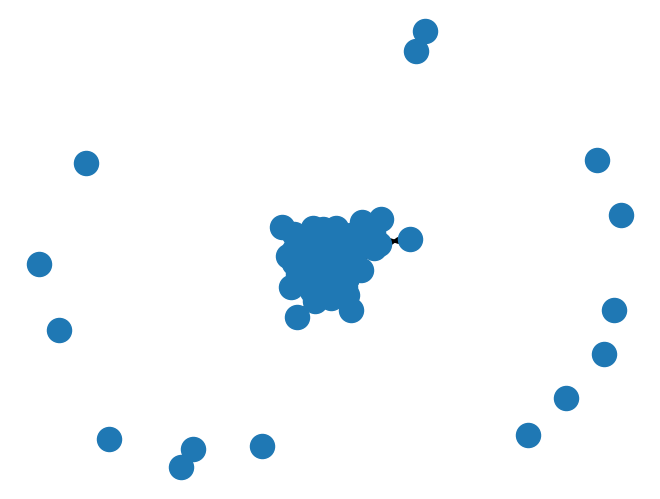

In [13]:
G = nx.DiGraph()
key_counts = dict(key_counts)

for k in key_counts.keys():
    G.add_node(k, label=k, size=key_counts[k])

for row in rule_list.values.tolist():
    G.add_edge(row[0], row[1], weight=row[2])


# pos = nx.spring_layout(G, seed=7)

# nx.draw_networkx_edges(G, pos, width=list(nx.get_edge_attributes(G, "weight").values()))

# # node labels
# nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# nx.draw_networkx_nodes(G,pos,node_size=[key_counts[n] for n in G.nodes])
nx.draw(G)

In [14]:
key_counts = dict(key_counts)
max_count = key_counts[max(key_counts, key= lambda x: key_counts[x])]

In [21]:
from d3graph import d3graph, vec2adjmat


source = rule_list['antecedents'].to_list()
target = rule_list['consequents'].to_list()
weights = rule_list['lift'].to_list()

adjmat = vec2adjmat(source, target, weight=weights)

# Initialize
d3 = d3graph(collision=3, charge=50000)
# Proces adjmat
d3.graph(adjmat)

# d3.set_node_properties(size=[key_counts[n] for n in adjmat.columns])
d3.set_node_properties(fontcolor='midnightblue', fontsize=16, edge_size=0)
for node in d3.node_properties.keys():
    d3.node_properties[node]['size'] = (key_counts[node.replace('_', ' ')] / max_count) * 50
    d3.node_properties[node]['label'] = node.replace('_', ' ')
    d3.node_properties[node]['color'] = 'green'

d3.set_edge_properties(edge_distance=100, directed=True)

[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Number of unique nodes: 104
[d3graph] INFO> Number of unique nodes: 104
[d3graph] INFO> Keep only edges with weight>0


[colourmap]> Warning: Colormap [Set1] can not create [13] unique colors! Available unique colors: [9].


In [22]:
d3.show(filepath='./conspiracy.html')

[d3graph] INFO> Slider range is set to [0, 10]
[d3graph] INFO> Write to path: [/home/ldtcoop/projects/conspiracy-network/conspiracy.html]
[d3graph] INFO> File already exists and will be overwritten: [/home/ldtcoop/projects/conspiracy-network/conspiracy.html]
